# Probabilistic Programming with Haskell

Siddhart Bath, Simeon Carstens, Matthias Meschede

_first published on www.tweag.io/blog_

#### imports

In [1]:
:e OverloadedStrings
:e ExistentialQuantification

import System.Random.MWC (createSystemRandom)
import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)
import Data.Aeson (ToJSON(toJSON), Value)
import Data.Aeson (encode)
import qualified Data.ByteString.Lazy.Char8 as BL
import Data.Text (Text, pack)

import Control.Monad (liftM2, replicateM, forM, forM_)
import Control.Monad.IO.Class (liftIO)
import Data.List (sort)
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Traced
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Inference.SMC as SMC
import Control.Monad.Bayes.Inference.RMSMC as RMSMC
import Control.Monad.Bayes.Sequential
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Traced.Static (Traced)
import Control.Monad.Bayes.Inference.SMC

import Numeric.Log
import Control.Monad.Bayes.Class

import Data.List (partition)

#### Plotting

In [2]:
barPlot :: Text -> VL.VLSpec
barPlot xName = 
    let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Nominal]
            . VL.position VL.Y [VL.PName "binnedData", VL.PAggregate VL.Count, VL.PmType VL.Quantitative, VL.PAxis [VL.AxTitle "count"]]
    in VL.asSpec [VL.mark VL.Bar [VL.MOpacity 1.0, VL.MColor "#a3c6de"], encoding []]

linePlot :: Text -> Text -> VL.VLSpec
linePlot xName yName = 
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative]
  in VL.asSpec [VL.mark VL.Line [VL.MColor "blue"], encoding []]

scatterBlue xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
  in VL.asSpec [VL.mark VL.Circle [VL.MColor "blue"], encoding []]
  
scatterGreen xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
  in VL.asSpec [VL.mark VL.Circle [VL.MColor "green"], encoding []]
  
scatterPlotWithColor :: Text -> Text -> Text -> (Double, Double) -> (Double, Double) -> VL.VLSpec
scatterPlotWithColor xName yName zName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
            . VL.color [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
  in VL.asSpec [VL.mark VL.Circle [], encoding []]

density2DPlot :: Text -> Text -> (Double, Double) -> (Double, Double) -> VL.VLSpec
density2DPlot xName yName (xmin, xmax) (ymin, ymax) = 
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PBin [VL.Nice False, VL.Steps [0.05, 0.5, 5.0], VL.Extent xmin xmax], VL.PmType VL.Quantitative]
            . VL.position VL.Y [VL.PName yName, VL.PBin [VL.Nice False, VL.Steps [0.05, 0.5, 5.0], VL.Extent ymin ymax], VL.PmType VL.Quantitative]
            . VL.color [ VL.MAggregate VL.Count, VL.MName "col", VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
  in VL.asSpec [VL.mark VL.Rect [], encoding []]

imagePlot :: Text -> Text -> Text -> VL.VLSpec
imagePlot xName yName zName =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Nominal, VL.PAxis [VL.AxGridOpacity 0.1]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Nominal, VL.PSort [VL.Descending], VL.PAxis [VL.AxGridOpacity 0.1]]
            . VL.fill [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
            . VL.stroke [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]],
                          VL.MLegend [VL.LType VL.GradientLegend]]
  in VL.asSpec [VL.mark VL.Rect [], encoding []]
  
imageFacetPlot :: Text -> Text -> Text -> VL.VLSpec
imageFacetPlot xName yName zName =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Ordinal, VL.PAxis [VL.AxGrid False]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Ordinal, VL.PSort [VL.Descending], VL.PAxis [VL.AxGrid False]]
            . VL.fill [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]], VL.MLegend [VL.LOrient VL.LOBottom]]
            . VL.stroke [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]],
                          VL.MLegend [VL.LOrient VL.LOBottom, VL.LDirection VL.Horizontal, VL.LType VL.GradientLegend]]
  in VL.asSpec [VL.mark VL.Rect [], encoding [], VL.width 200,  VL.height 100]

data SpecGrid = H [[VL.VLSpec]] | V [[VL.VLSpec]] | L [VL.VLSpec] | S VL.VLSpec | F (Text, Int, VL.VLSpec)

data InputData = Cols [(Text, VL.DataValues)]
               | File FilePath

plot :: (Double, Double) -> SpecGrid -> InputData -> VL.VegaLite
plot (figw,figh) specGrid dataPoints =
    let description = VL.description "Plot"
        dat' = case dataPoints of
            Cols cols -> foldl (.) (VL.dataFromColumns []) (map (uncurry VL.dataColumn) cols) []
            File fp -> VL.dataFromSource (pack fp) []
        configure = VL.configure
            . VL.configuration (VL.Axis
                                        [ VL.Domain False,
                                          VL.LabelColor "#7F7F7F",
                                          VL.LabelPadding 4,
                                          VL.TickColor "#7F7F7F",
                                          VL.TickSize 5.67,
                                          VL.Grid True,
                                          VL.GridColor "#FFFFFF"
                                          ])
        spec = case specGrid of
            S s -> VL.layer [s]
            L ls -> VL.layer ls
            H lss -> VL.hConcat (map (VL.asSpec . (:[]) . VL.layer) lss)
            V lss -> VL.vConcat (map (VL.asSpec . (:[]) . VL.layer) lss)
            F (_, _, s) -> VL.specification s
        facet = case specGrid of
            F (field, nColumns, _) -> [VL.columns $ fromIntegral nColumns, VL.facetFlow [VL.FName field, VL.FmType VL.Nominal]]
            _   -> [VL.width figw,  VL.height figh]
    in VL.toVegaLite $ [VL.background "#f9f9f9", configure [], description, dat', spec] ++ facet

### Introduction

In this blog post series, we're going to lead you through Bayesian modeling in Haskell with the [`monad-bayes`](https://github.com/adscib/monad-bayes/tree/647ba7cb5a98ae028600f3d828828616891b40fb) library.
We start this series gradually with some simple binary models, move next to linear regression, and finish by building a simple neural network that we "train" with a Metropolis-Hastings sampler.
You don't need any prior knowledge of Bayesian modeling to understand and learn from these posts—and we keep the code simple and understandable for Haskell newcomers.

Want to make this post interactive? Try our [notebook version](https://gist.github.com/MMesch/dee0659e480b572d0b36088a2b08cc57). It includes a Nix shell, the required imports, and some helper routines for plotting. Let's start modeling! 

## Part 1: First Steps

### Sampling

In this first part of the series, we introduce two fundamental concepts of `monad-bayes`: `sampling` and `scoring`.
We examine them based on one of the simplest probabilistic models that we can think of—a model that represents a `True` or `False` choice.
You can use it, for example, to describe the answer to a question such as "Did it rain yesterday?".

The model is parameterized by a boolean `b`, and in this simple case, `b` is also directly the model output.
Without additional information, we assign equal probabilities `0.5` to each value that `b` can take (50% `True`, 50% `False`).
In other words, we get the model parameter `b` from a discrete uniform [prior](https://en.wikipedia.org/wiki/Prior_probability) distribution.

Let's see how the model looks like in the`monad-bayes`library:

In [3]:
model1 :: MonadSample m => m Bool
model1 = do
    b <- uniformD [False, True]
    return b

Line 2: Redundant return
Found:
do b <- uniformD [False, True]
   return b
Why not:
do uniformD [False, True]

In `monad-bayes` a model is expressed through the typeclass `MonadSample`.
The `MonadSample` typeclass provides a function `random` to our `model1` that returns a random sample from it.
The type of the sample itself is set to `Bool` in our case.

We define our model by binding together other basic `MonadSample` models.
In this case, for example, we build our model from the `uniformD` distribution that is provided by `monad-bayes`
The model, that is the chain of actions that are bound together in _MonadSample_, is not executed until we start sampling from the model.
Once we sample, the resulting chain of actions that is executed is simple:
draw `b` from a discrete uniform distribution (_uniformD_) and then return its value.

Sampling can be executed with:

In [4]:
sampleIOfixed model1

False

We can get a list of samples with Haskell's `replicateM` function:

In [5]:
nsamples = 1000
samples <- sampleIOfixed $ replicateM nsamples model1

Then plot the result afterwards with [Vega-Lite](https://github.com/vega/vega-lite#readme) (module `VL`).
You can find our custom plotting functions for Vega-Lite in the notebook.

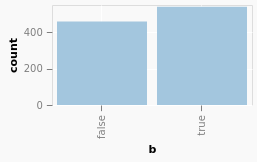

In [6]:
vlShow $ plot (200, 100) (L [barPlot "b"]) (Cols [("b", VL.Booleans samples)])

So far, so good: we now have a model that represents a distribution of `True/False` values and we can draw samples from it.
But how can we include observations into this model?

## Scoring

Consider again `model1` as the answer to "Did it rain yesterday?".
What if we found out "Yes, it did rain yesterday!"?
To include this new knowledge, we need to update the distribution of the model parameter `b`.

In `monad-bayes` the function `score` is responsible for making samples more or less likely—by a factor.
Don't worry if you are mystified by this explanation, we'll explain more in a moment.
But first check out `model2` that uses `score` to include the observation:

In [7]:
model2 :: MonadInfer m => m Bool
model2 = do
    b <- uniformD [False, True]
    score (if b then 1.0 else 0.0)
    return b

Notice the new typeclass `MonadInfer` that allows us to use `score` in addition to sampling.
Instead of a single operation, the model is now a chain of actions: _sample_, _score_, …

Here's a naive idea of how this could work:
assume that the representation of the probability distribution of `b` was a list of tuples `[(0.5, True), (0.5, False)]`.
We would multiply this distribution with the distribution of my observation "Yes, it did rain yesterday!", that is with `[(1, True), (0, False)]`.
Then we would normalize the updated probabilities such that they sum to one, and the job is done.

So are we secretly tracking the probability of all samples—the full distribution—at every step (in the Haskell world a.k.a. some variant of the [_Dist_ monad](http://www.randomhacks.net/files/build-your-own-probability-monads.pdf))?
Granted, in the case of a `True`/`False` question this might be a good approach—_but this is not what is happening here for very good reasons_:

To update a sample's probability as described above we need to track all samples with their probabilities and run global normalization operations on them.
We are essentially running computations with full distributions over all possible values.
This quickly becomes intractable because a model can basically be any Haskell function with lots and lots of possible outcomes.

`monad-bayes` and similar probabilistic frameworks use an elegant approach that do what we want _without dragging around full distributions_.
The trick behind is to approximate the outcome distribution by drawing successive samples from it.
It turns out that it is enough to know the _relative probability_ of two samples at a time to do this.
The relative probability of the two samples is independent of the probability of other samples—computations on full distributions are thus reduced to computations on samples.
With appropriate sampling algorithms ([MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)) we can approximate the outcome distribution despite this limited knowledge.
It is difficult to overstate the implications:
with MCMC we can address all kinds of sampling related problems in a probabilistic manner that would be completely inaccessible otherwise.

Let's get back to the `score` function that modifies the probability to pull a certain sample from the distribution.
We now understand that it multiplies the _relative probability_ to observe a sample compared to any other with a factor.
This means that the sample's probability is left untouched if this factor is `1`.
If this factor is `10`, the sample's relative probability is increased ten fold with respect to any other sample.
If this factor is `0`, the sample's probability is set to `0`.

Here is `model2` expressed in words: (a) draw a sample from `[True, False]` with equal probability,
and (b) multiply the relative probability of a sample with value `True` with `1` and of a sample with value `False` with `0`.

An appropriate sampler can trace and accumulate the score factor of a sample to compare with the score factor of other samples.
The accumulated score factors give us access to the relative probability of the two samples, and then we can use MCMC to start sampling.
We won't go into detail here about how tracing and accumulating works or which two samples we are actually comparing.
`monad-bayes` provides a few samplers that can go through this process in different ways.
We include here the `prior` and the `mh` ([Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) sampler) functions before our well known `sampleIOfixed` function to use an MCMC sampler.
Hopefully, the general idea became clear enough here. We'll provide more of the details later in this series.

The final result looks like this:

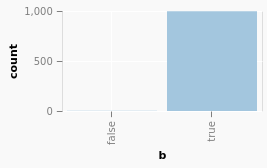

In [8]:
nsamples = 1000
samples <- sampleIOfixed $ prior $ mh nsamples model2
vlShow $ plot (200, 100) (L [barPlot "b"]) (Cols [("b", VL.Booleans samples)])

Voilà, we wrote down a model (answer to "Did it rain yesterday?") with an uninformed (uniform) prior, and updated it based on the observation "It rained yesterday!".
The distribution of parameter `b` after scoring—its posterior distribution—has probability `1` for True and probability `0` for False.
The operations that we needed to figure out the posterior distribution were _random_ and _score_.

### Multiple parameters

Let's move onwards to more complex models:
What if we considered a model with two parameters?
Both parameters are drawn independently from uniform _continuous_ distributions between `-1` and `1`.
Again, we want to score this model.
This time, we use the function `condition` that is a short form for scoring with `1` or `0` based on a condition.
The new model becomes:

In [9]:
model3 :: MonadInfer m => m (Double, Double)
model3 = do
    b <- uniform (-1) 1
    m <- uniform (-1) 1
    condition $ (b-m) > 0
    return (b, m)

The principal approach is the same: pick sample `b`, pick sample `m`, modify the joint sample probability based on a condition, and return the values of both samples in a tuple.
If we run this through the Metropolis-Hastings sampler, we get:

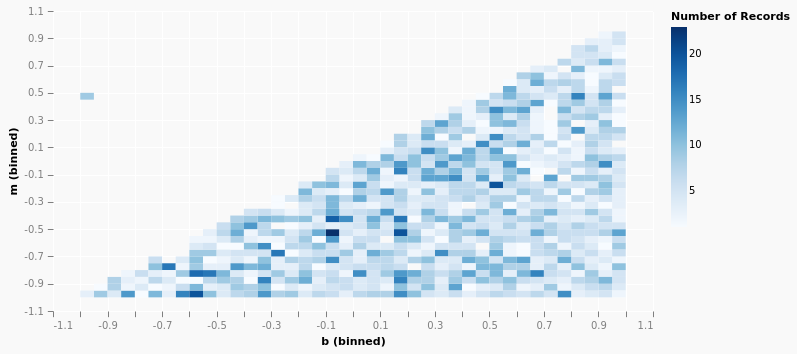

In [10]:
nsamples = 5000
modelsamples <- sampleIOfixed $ prior $ mh nsamples model3
(xValues, yValues) = unzip modelsamples
vlShow $ plot (600, 300)
              (L [density2DPlot "b" "m" (-1.1,1.1) (-1.1,1.1)])
              (Cols [("b", VL.Numbers xValues), ("m", VL.Numbers yValues)])

The resulting distribution in the plot above is `0` where `b<m`, and approximately uniform when `b>m`, as we'd expect.
You might spot the initial state of the Markov chain as a faint rectangle in the `b<m` region.

How about multiple conditions?
Remember, we can freely bind operations together so it shouldn't be a problem.
This model chains two sampling and two condition operations:

In [11]:
model4 :: MonadInfer m => m (Double, Double)
model4 = do
    b <- uniform (-1) 1
    m <- uniform (-1) 1
    condition $ (b-m) > 0
    condition $ (b+m) > 0
    return (b, m)

And it produces the expected result:

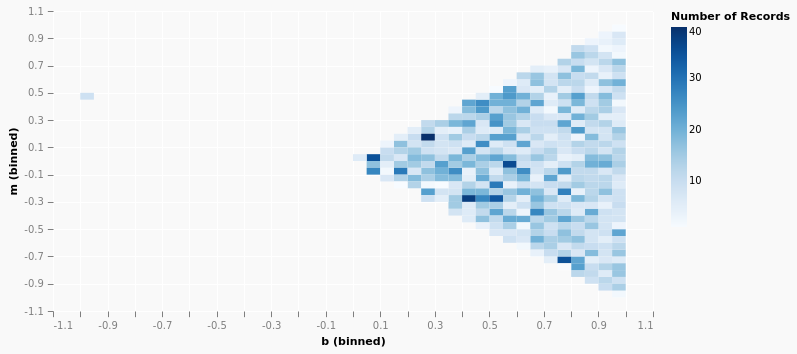

In [12]:
nsamples = 5000
modelsamples <- sampleIOfixed $ prior $ mh nsamples model4
(xValues, yValues) = unzip modelsamples
vlShow $ plot (600, 300)
              (L [density2DPlot "b" "m" (-1.1,1.1) (-1.1,1.1)])
              (Cols [("b", VL.Numbers xValues), ("m", VL.Numbers yValues)])

### Conclusions

We have seen how we can build models and examine related probability distributions by drawing samples and modifying their relative probabilities with the `score` function.
The MCMC approach taken by`monad-bayes`and similar frameworks avoids computations with full distributions, and works with individual samples to enormously simplify life.
`monad-bayes`can, therefore, be used to approximate large and complex distributions—something that quickly comes in handy.
We can use`monad-bayes`to approximate the distribution of the return values of basically any Haskell function for a given input distribution.
This could even be the return values of entire programs.
Even better—we can use `score` to infer the input distribution if we have a way of scoring samples based on observations.

We hope you enjoyed this first post in our _Probabilistic Programming with monad&#8209;bayes Series_ and learned lots! Now, you're ready to build more general statistical models using these building blocks, and proceed to linear regression in our next post. We hope you join us!

part 2 (link to come)

## Notes

We use [this GitHub version](https://github.com/adscib/monad-bayes/tree/647ba7cb5a98ae028600f3d828828616891b40fb) of`monad-bayes`in our posts and notebooks since it's neither on Hackage nor Stackage right now. Here are two original articles you may want to check out:

* [Practical Probabilistic Programming with Monads](http://mlg.eng.cam.ac.uk/pub/pdf/SciGhaGor15.pdf)
* [Functional Programming for Modular Bayesian Inference](http://denotational.co.uk/publications/scibior-kammar-ghahramani-funcitonal-programming-for-modular-bayesian-inference.pdf)